<a href="https://colab.research.google.com/github/sayakpaul/SimCLR-in-TensorFlow-2/blob/imagenet-subset/Supervised_Full_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
print(tf.__version__)

2.2.0-rc4


In [2]:
!nvidia-smi

Fri May  8 15:22:40 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# Gather dataset
!git clone https://github.com/thunderInfy/imagenet-5-categories

In [0]:
# Other imports
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import matplotlib.pyplot as plt
from imutils import paths
from tqdm import tqdm
import tensorflow as tf
import numpy as np
import cv2

# Random seed fixation
tf.random.set_seed(666)
np.random.seed(666)

In [5]:
# Train and test image paths
train_images = list(paths.list_images("imagenet-5-categories/train"))
test_images = list(paths.list_images("imagenet-5-categories/test"))
print(len(train_images), len(test_images))

1250 250


In [0]:
def prepare_images(image_paths):
    images = []
    labels = []

    for image in tqdm(image_paths):
        image_pixels = plt.imread(image)
        image_pixels = cv2.resize(image_pixels, (224, 224))
        image_pixels = image_pixels/255.

        label = image.split("/")[2].split("_")[0]

        images.append(image_pixels)
        labels.append(label)

    images = np.array(images)
    labels = np.array(labels)

    print(images.shape, labels.shape)

    return images, labels

In [7]:
X_train, y_train = prepare_images(train_images)
X_test, y_test = prepare_images(test_images)

  9%|▉         | 23/250 [00:00<00:01, 222.03it/s]

(1250, 224, 224, 3) (1250,)


100%|██████████| 250/250 [00:01<00:00, 210.60it/s]


(250, 224, 224, 3) (250,)


In [0]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

In [0]:
# Set up TensorFlow dataset for performance optimization

AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 64

train_ds = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train_enc))
    .shuffle(1024)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

test_ds = (
    tf.data.Dataset.from_tensor_slices((X_test, y_test_enc))
    .shuffle(1024)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

In [0]:
# Architecture utils
def get_resnet():
    base_model = tf.keras.applications.ResNet50(include_top=False, weights=None, input_shape=(224, 224, 3))
    base_model.trainabe = True
    
    inputs = Input((224, 224, 3))
    features = base_model(inputs, training=True)
    pooled_features = GlobalAveragePooling2D()(features)

    pooled_features = Dense(256)(pooled_features)
    pooled_features = Activation("relu")(pooled_features)
    outputs = Dense(5, activation="softmax")(pooled_features)

    resnet_simclr = Model(inputs, outputs)

    return resnet_simclr

In [0]:
def plot_training(H):
	with plt.xkcd():
		plt.plot(H.history["loss"], label="train_loss")
		plt.plot(H.history["val_loss"], label="val_loss")
		plt.plot(H.history["accuracy"], label="train_acc")
		plt.plot(H.history["val_accuracy"], label="val_acc")
		plt.title("Training Loss and Accuracy")
		plt.xlabel("Epoch #")
		plt.ylabel("Loss/Accuracy")
		plt.legend(loc="lower left")
		plt.show()

In [0]:
# Early Stopping to prevent overfitting
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, verbose=2, restore_best_weights=True)

In [12]:
get_resnet().summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               524544    
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 1285      
Total params: 24,113,541
Trainable params: 24,060,421
Non-trainable params: 53,120
____________________________________________

In [16]:
# Train the supervised model with full data
model = get_resnet()
model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
              optimizer=tf.keras.optimizers.Adam(1e-3))
history = model.fit(train_ds,
                    validation_data=test_ds,
                    epochs=50,
                    callbacks=[es])

Epoch 1/50
20/20 [==============================] - 17s 865ms/step - loss: 2.6779 - accuracy: 0.3408 - val_loss: 1.3187 - val_accuracy: 0.4560
Epoch 2/50
20/20 [==============================] - 13s 649ms/step - loss: 1.3394 - accuracy: 0.4864 - val_loss: 1.2509 - val_accuracy: 0.4920
Epoch 3/50
20/20 [==============================] - 13s 662ms/step - loss: 1.1381 - accuracy: 0.5304 - val_loss: 1.1165 - val_accuracy: 0.5280
Epoch 4/50
20/20 [==============================] - 14s 683ms/step - loss: 1.1207 - accuracy: 0.5616 - val_loss: 1.0527 - val_accuracy: 0.5480
Epoch 5/50
20/20 [==============================] - 14s 697ms/step - loss: 0.9908 - accuracy: 0.6032 - val_loss: 1.0204 - val_accuracy: 0.6360
Epoch 6/50
20/20 [==============================] - 14s 689ms/step - loss: 0.9786 - accuracy: 0.5936 - val_loss: 1.0376 - val_accuracy: 0.6240
Epoch 7/50
20/20 [==============================] - 14s 679ms/step - loss: 0.9057 - accuracy: 0.6288 - val_loss: 0.9962 - val_accuracy: 0.5840

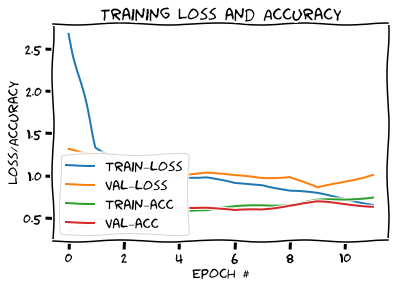

In [17]:
plot_training(history)